# Using convlutions to generalize
---
This chapter covers
- Understanging convolution
- Building a convolutional neural network
- Creating custom nn.Module subclasses 
- The differece between the module and functional APIs
- Design choices for neural networks

we need to use the dataset from the last chapter

In [5]:
# first download the dataset using datasets module in torchvision
from torchvision import datasets
from torchvision import transforms
import torch

data_path = './data/'

tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

# build a normalize transform
norm = transforms.Normalize(mean, std)

# use compose to put two transforms together
trans = transforms.Compose([
    transforms.ToTensor(),
    norm
])

# normalized dataset
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=trans)
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=trans)

# pick out these two kinds
label_map = {0:0, 2:1}  # reset the label to 0, 1
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
Files already downloaded and verified


In [1]:
# implement a conv
import torch
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)   # in_ch=3, out_ch=16 
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [7]:
# test on a single image
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

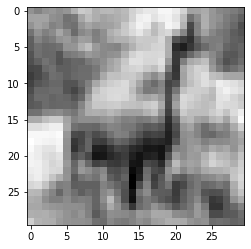

In [8]:
import matplotlib.pyplot as plt

plt.imshow(output[0, 0].detach(), cmap='gray')

In [9]:
# add padding to keep the same dimension
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))